In [1]:
# imports
import numpy as np
import pandas as pd

In [32]:
# data analysis and wrangling
import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import sklearn
from sklearn import tree
from sklearn import preprocessing 

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

# Plotting
import seaborn as sns
%matplotlib inline
sns.set()

# Operating SYStem stuff
import os

# Ignore
import warnings
warnings.filterwarnings("ignore")#, category=FutureWarning)

In [3]:
# Get paths for data CSVs
train_path = os.path.join('data', 'titanic_train.csv')
test_path  = os.path.join('data','test.csv')

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
# gender_submission = pd.read_csv('/kaggle/input/titanic/gender_submission.csv')

## Exploratory Data Analysis

In [4]:
#Recommendations for EDA:
#1. Make boxplots of each numerical feature to get visual info about basic statistical info
#2. Make a correlation heatmap of the features to detect multicollinearity
#3. Make pivot tables for categorical features against the target

# These were tips from the notebook that I didn't actually use for EDA

In [5]:
# Main theme throughout the EDA: Try to find a proper way of visualizing / displaying
# the relationship between a variable and the 'Survived' label

In [6]:
train_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

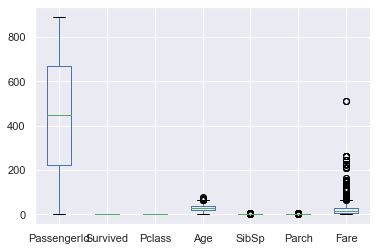

In [7]:
train_df.boxplot()

In [8]:
#train_df[['Age','Pclass']].boxplot()

In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [10]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


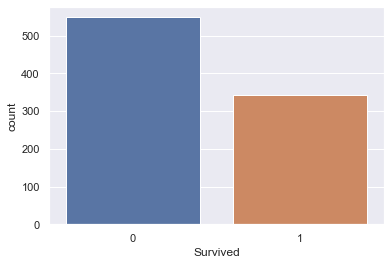

In [11]:
# How many died? Is it balanced?
sns.countplot(x='Survived', data = train_df)

In [12]:
# Percentage of survived
print(train_df.Survived.sum()/train_df.Survived.count())

0.3838383838383838


In [13]:
train_df.groupby(['Survived','Sex'])['Survived'].count()

Survived  Sex   
0         female     81
          male      468
1         female    233
          male      109
Name: Survived, dtype: int64

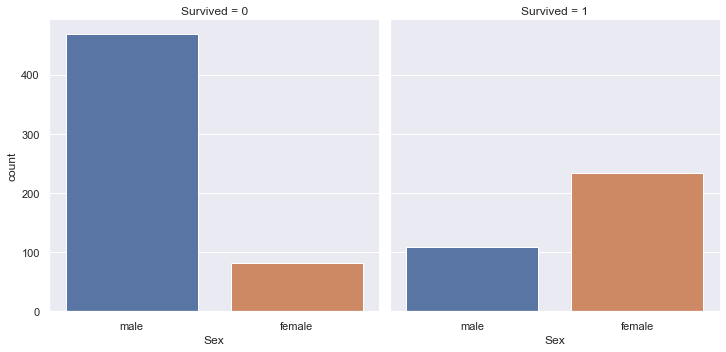

In [14]:
sns.catplot(x='Sex', col='Survived', kind='count', data=train_df);

In [15]:
print("% of women survived: " , train_df[train_df.Sex == 'female'].Survived.sum()/train_df[train_df.Sex == 'female'].Survived.count())
print("% of men survived:   " , train_df[train_df.Sex == 'male'].Survived.sum()/train_df[train_df.Sex == 'male'].Survived.count())

% of women survived:  0.7420382165605095
% of men survived:    0.18890814558058924


In [16]:
# Baseline model of women survived and mean died = 0.766 accuracy!

In [17]:
pd.crosstab(train_df.Pclass, train_df.Survived).style.background_gradient(cmap='autumn_r')
#, margins=True

Survived,0,1
Pclass,,
1,80,136
2,97,87
3,372,119


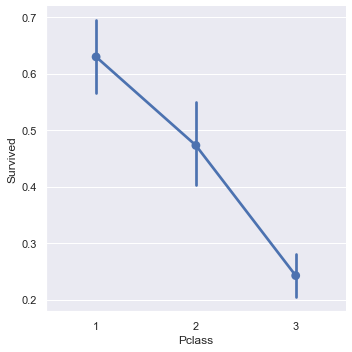

In [18]:
sns.catplot('Pclass','Survived', kind='point', data=train_df);

In [19]:
pd.crosstab([train_df.Sex, train_df.Survived], train_df.Pclass,margins=True).style.background_gradient(cmap='autumn_r')

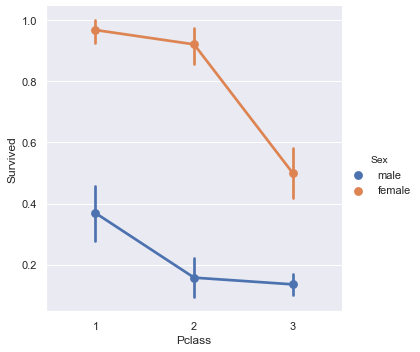

In [20]:
sns.catplot('Pclass','Survived',hue='Sex', kind='point', data=train_df);

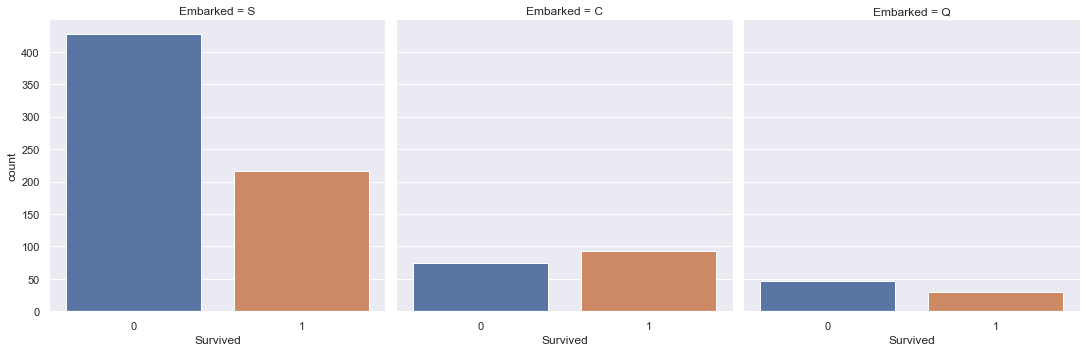

In [21]:
sns.catplot(x='Survived', col='Embarked', kind='count', data=train_df);

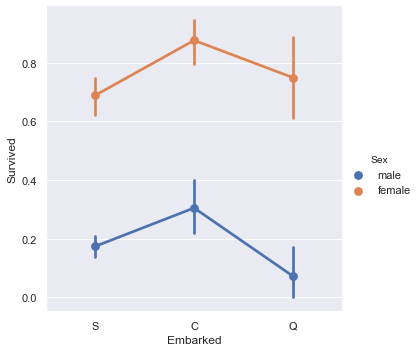

In [22]:
sns.catplot('Embarked','Survived', hue= 'Sex', kind='point', data=train_df);

$\textbf{Age: Continuous numerical to 8 bins}$ 

In [23]:
for df in [train_df, test_df]:
    df['Age_bin']=np.nan
    for i in range(8,0,-1):
        df.loc[ df['Age'] <= i*10, 'Age_bin'] = i

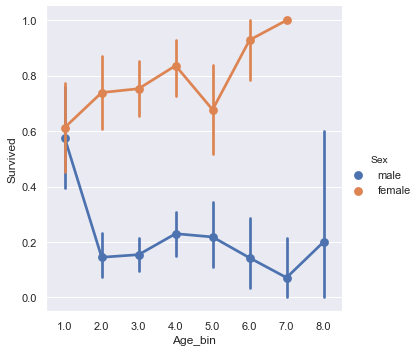

In [24]:
sns.catplot('Age_bin','Survived',hue='Sex',kind='point',data=train_df);

In [25]:
pd.crosstab([train_df.Sex, train_df.Survived], [train_df.Age_bin, train_df.Pclass], margins=True).style.background_gradient(cmap='autumn_r')

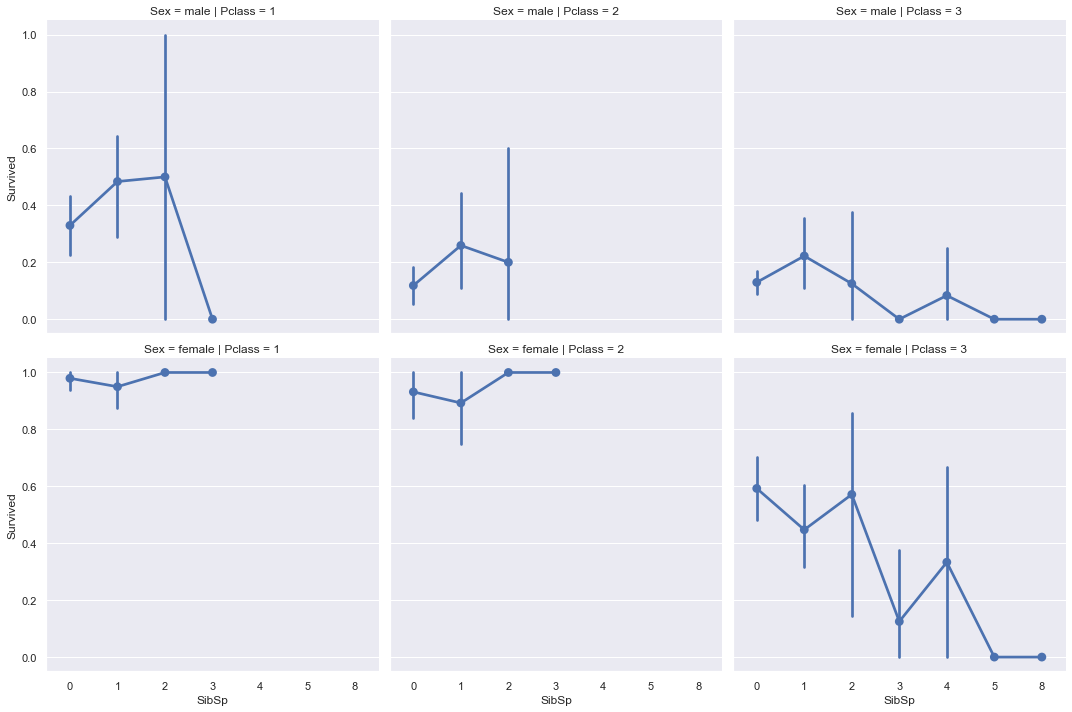

In [26]:
sns.catplot('SibSp','Survived', col='Pclass' , row = 'Sex', kind='point', data=train_df);

In [27]:
pd.crosstab([train_df.Sex, train_df.Survived], [train_df.SibSp, train_df.Pclass], margins=True).style.background_gradient(cmap='autumn_r')


$\textbf{Fare: continuous numerical to 12 bins}$

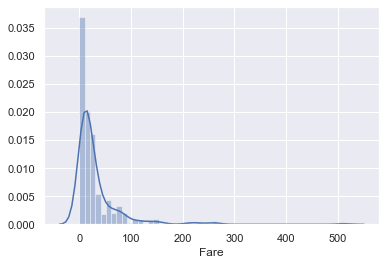

In [28]:
sns.distplot(train_df['Fare']);

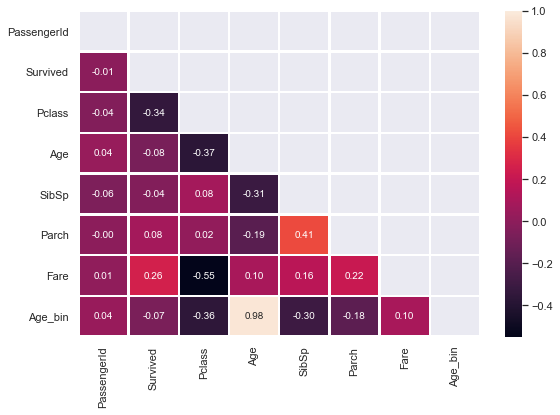

In [29]:
# Correlation matrix
corr = train_df.corr()
mask_ut = np.triu(np.ones(corr.shape)).astype(np.bool) # create a mask

f,ax = plt.subplots(figsize=(9,6))
sns.heatmap(corr, annot = True, linewidths=1.5 , fmt = '.2f',ax=ax, mask = mask_ut)
plt.show()

## Preprocessing

In [33]:
# First word is Last Name, so get it and make feature
train_df['LastName'] = train_df['Name'].str.split(',', expand=True)[0]
test_df['LastName'] = test_df['Name'].str.split(',', expand=True)[0]

# Get one "full" dataset
ds = pd.concat([train_df, test_df], sort = False)

In [34]:
#Checking survival rate by LastName
ds[['LastName', 'Survived']].groupby('LastName', as_index=False).mean().sort_values(by='Survived', ascending=False).head(10)

,LastName,Survived
435,Lehmann,1.0
287,Glynn,1.0
326,Hedman,1.0
325,Healy,1.0
323,Hays,1.0
322,Hawksford,1.0
320,Hassab,1.0
693,Ryerson,1.0
696,Saalfeld,1.0
312,Harder,1.0


In [35]:
#Creating two new features Family_died and FamilySuvived
sur = list()
died = list()

for index, row in ds.iterrows():
    s = ds[(ds['LastName']==row['LastName']) & (ds['Survived']==1)]
    d = ds[(ds['LastName']==row['LastName']) & (ds['Survived']==0)]
    s=len(s)
    if row['Survived'] == 1:
        s-=1
    d=len(d)
    if row['Survived'] == 0:
        d-=1
    sur.append(s)
    died.append(d)
ds['FamilySurvived'] = sur
ds['FamilyDied'] = died

In [36]:
# Dropping the Name and Last name
ds=ds.drop(['Name','LastName', 'PassengerId'], axis=1)

In [38]:
#Creating new feature: Familysize
ds['FamilySize'] = ds['SibSp'] + ds['Parch'] + 1
    
ds[['FamilySize', 'Survived']].groupby('FamilySize', as_index=False).mean().sort_values(by='Survived', ascending=False)

,FamilySize,Survived
3,4,0.724138
2,3,0.578431
1,2,0.552795
6,7,0.333333
0,1,0.303538
4,5,0.200000
5,6,0.136364
7,8,0.000000
8,11,0.000000


In [39]:
# Bin the family sizes
ds.loc[(ds['FamilySize']>1) & (ds['FamilySize']<=4), 'FamilySize'] = 0
ds.loc[(ds['FamilySize']==7) & (ds['FamilySize']==1), 'FamilySize'] = 1
ds.loc[(ds['FamilySize']==5) & (ds['FamilySize']==6), 'FamilySize'] = 2
ds.loc[(ds['FamilySize']>=8), 'FamilySize'] = 3

In [42]:
ds['IsAlone'] = 0
ds.loc[ds['FamilySize'] == 1, 'IsAlone'] = 1